In [6]:
%load_ext autoreload
%autoreload 2

import torch
from einops import rearrange
from text3d2video.artifacts.multiview_features_artifact import MVFeaturesArtifact
from text3d2video.wandb_util import first_used_artifact_of_type
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil
import text3d2video.wandb_util as wu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mv_features_tag  = 'deadpool-mv-features:latest'
mv_features = wu.get_artifact(mv_features_tag)
mv_features = MVFeaturesArtifact.from_wandb_artifact(mv_features)
animation = mv_features.get_animation_from_lineage()
mesh = animation.load_static_mesh()

mv_features_run_config = mv_features.logged_by().config

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact deadpool-mv-features:latest, 592.93MB. 298 files... 
wandb:   298 of 298 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [3]:
from tqdm import tqdm
from text3d2video.ipython_utils import display_ims, display_ims_grid
from math import sqrt

# attn1 layers seem to be much more appearance based, look into where cross and self attention takes place
layers = [
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

views = mv_features.get_ims()

rgb_maps = []

for layer in tqdm(layers):
    feature_id = {"layer": layer, "timestep": 20}

    # get features for layer and timestep
    features = torch.stack([mv_features.get_feature(i, feature_id) for i in mv_features.view_indices()])
    n_views, seq_len, channels = features.shape
    feature_map_size = int(sqrt(seq_len))

    # get all individual features for PCA
    features = rearrange(features, 'v t c -> (v t) c')
    pca = RgbPcaUtil(features.shape[1])
    pca.fit(features)
    
    # reshape reature maps to square
    feature_maps = rearrange(features, '(v h w) c -> v c h w', v=n_views, h=feature_map_size, w=feature_map_size)
    feature_maps_rgb = [pca.feature_map_to_rgb_pil(feature_map) for feature_map in feature_maps]
    rgb_maps.append(feature_maps_rgb)


/home/jorge/thesis/text3d2video/artifacts/multiview_features_artifact.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.folder / "cameras.pt")
  0%

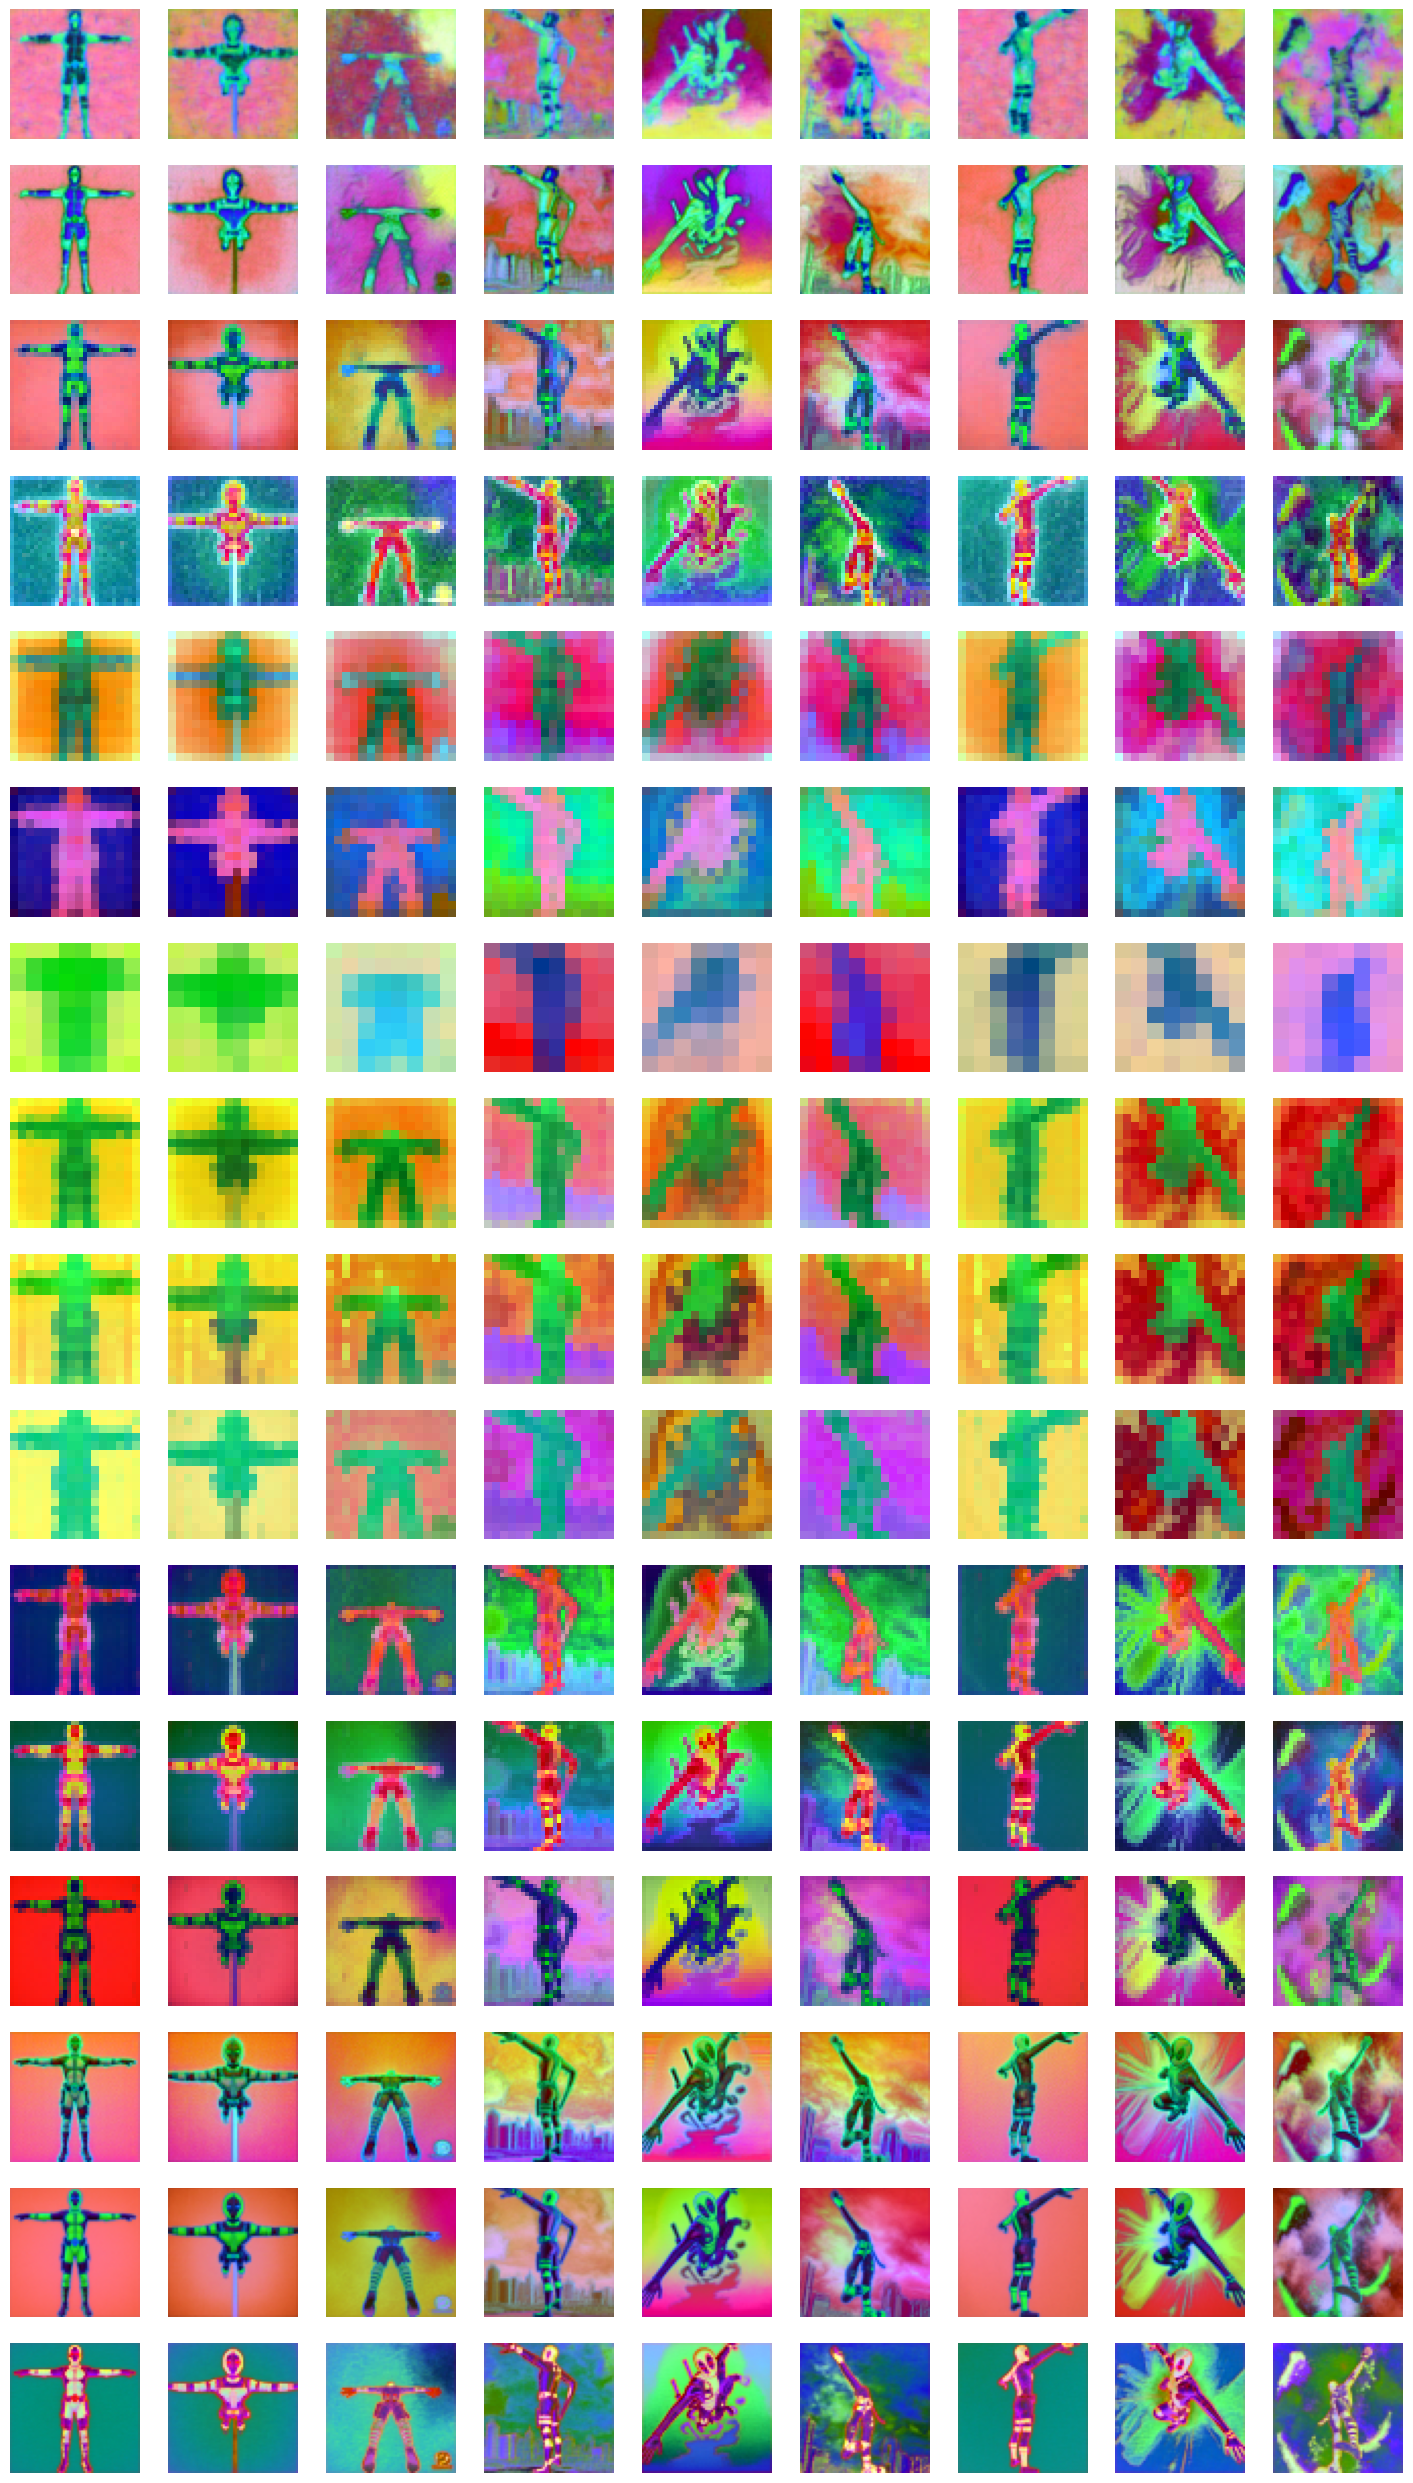

In [5]:
n_rows = len(layers)
n_cols = len(rgb_maps[0])

scale = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale))

for r_i in range(n_rows):
    for c_i in range(n_cols):
        ax = axs[r_i, c_i]
        ax.imshow(rgb_maps[r_i][c_i])
        ax.axis("off")

320


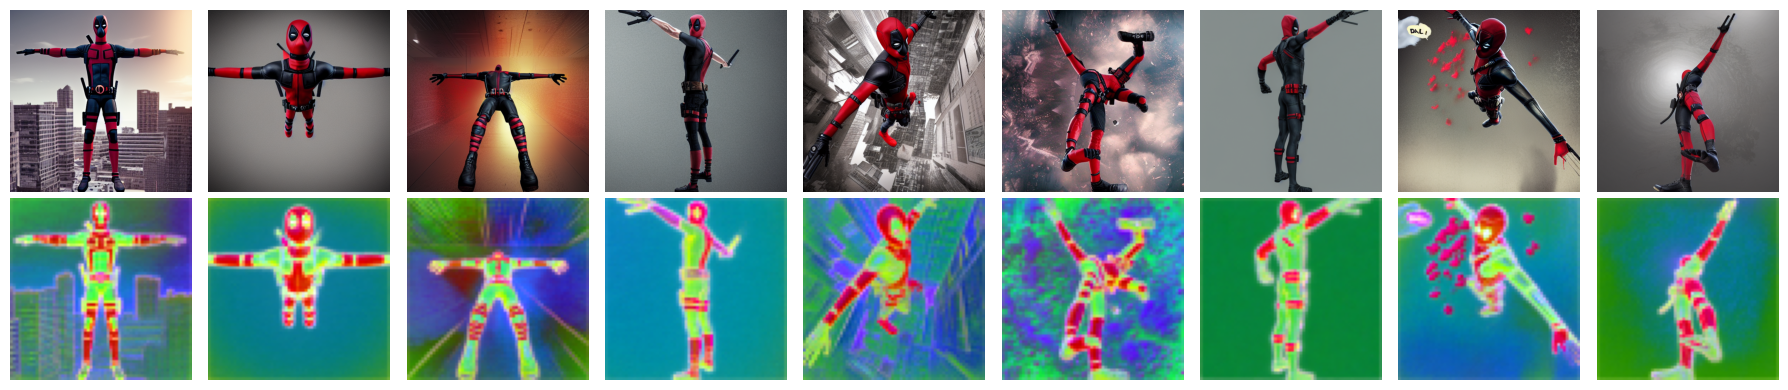

In [27]:

views = mv_features.get_ims()

layer_name = "down_blocks.0.attentions.1.transformer_blocks.0.attn1"
layer_name = "down_blocks.1.attentions.1.transformer_blocks.0.attn1"
layer_name = "down_blocks.2.attentions.1.transformer_blocks.0.attn1"
layer_name = "up_blocks.3.attentions.2.transformer_blocks.0.attn1"

feature_id = {"layer": layer_name, "timestep": 20}
features = torch.stack([mv_features.get_feature(i, feature_id) for i in mv_features.view_indices()])

n_views, seq_len, channels = features.shape
print(channels)

feature_map_size = int(sqrt(seq_len))
features = rearrange(features, 'v t c -> (v t) c')

# fit PCA
pca = RgbPcaUtil(features.shape[1])
pca.fit(features)

# reshape reature maps to square
feature_maps = rearrange(features, '(v h w) c -> v c h w', v=n_views, h=feature_map_size, w=feature_map_size)
feature_maps_rgb = [pca.feature_map_to_rgb_pil(feature_map) for feature_map in feature_maps]

display_ims_grid([views, feature_maps_rgb], scale=2)